In [1]:
import numpy as np
import torch
import scipy
import matplotlib.pyplot as plt
import sklearn.decomposition
from sklearn import svm
from collections import defaultdict
from collections import Counter
from matplotlib import rcParams
import matplotlib.patches as mpatches
import seaborn
import os

seaborn.set(font='Arial')
plt.style.use('default')
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 11
plt.rcParams.update({"text.color": 'k'})

import sys
sys.path.append('./')
import auxiliary_bed_functions as abf

date = '12_16_19' # Change this to today's date for output names.

input_dir = '../tensor_input/' # directory where the HOSVD files can be found
file_prefix = 'leiomyoma_HOSVD_final' # prefix used for input files
output_dir = '../' # directory to write output

# Create some directories for writing output files
# and figures
def check_dir(path):
    if(not os.path.exists(os.path.dirname(path))):
        os.makedirs(path)

check_dir(output_dir + 'figures/')
check_dir(output_dir + 'region_files/')
check_dir(output_dir + 'figures/' + 'figure1_panels/')
check_dir(output_dir + 'figures/' + 'figure2_panels/')
check_dir(output_dir + 'figures/' + 'figure3_panels/')
check_dir(output_dir + 'figures/' + 'figure4_panels/')
check_dir(output_dir + 'figures/' + 'figureS1_panels/')
check_dir(output_dir + 'figures/' + 'figureS2_panels/')
check_dir(output_dir + 'figures/' + 'figureS3_panels/')
check_dir(output_dir + 'figures/' + 'figureS4_panels/')

In [2]:
# Read in the projections from the tensor decomposition.
fp = open( input_dir + file_prefix + '_projections.txt', 'r')

index = []
projections = []
for line in fp:
    l = line.strip().split(':')
    index.append([int(l[0].split(',')[0]), int(l[0].split(',')[1]), int(l[0].split(',')[2])])
    projections.append(l[1].strip().split(','))

print(len(index), len(projections[0]))
n_pt = 21
n_as = 3
n_gr = 2
fp.close()

sample_proj = np.zeros((n_gr, n_pt, n_as, len(projections[0])))

for k in range(0,len(projections)):
    sample_proj[index[k][0], index[k][1], index[k][2]] = projections[k]

126 126


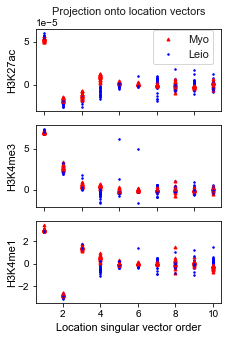

In [3]:
# Figue 1B (stacked projections)
fig = plt.figure(figsize=(3.27087,4.82))

n_proj = 10
assay_name = ['H3K27ac', 'H3K4me3', 'H3K4me1']
ax = []
for k in range(n_as):
    assay = k
    ax.append(fig.add_subplot(311+k))
    l1, = ax[k].plot(sample_proj[0, 0, assay][0:n_proj],'^', markersize=3, c=(1,0,0,1))
    l2, = ax[k].plot(sample_proj[1, 0, assay][0:n_proj],'.', markersize=3, c=(0,0,1,1))
    for i in range(1,n_pt):
        ax[k].plot(sample_proj[0, i, assay][0:n_proj],'^', markersize=3, c=(1,0,0,1))
        ax[k].plot(sample_proj[1, i, assay][0:n_proj],'.', markersize=3, c=(0,0,1,1))

    if(k == 0):
        plt.title('Projection onto location vectors',fontsize=11,y=1.1)
        ax[k].legend([l1, l2], ["Myo", "Leio"], fontsize=11, bbox_to_anchor=(0.6,0.50))
        
    ax[k].set_ylabel(assay_name[k],fontsize=11)
    ax[k].get_yaxis().set_label_coords(-0.1,0.5)
    if(k == 0):
        plt.yticks([0,5*10**-5])
    elif(k == 1):
        plt.yticks([0,5*10**-5])
    else:
        plt.yticks([-2*10**-5,0,2*10**-5])
    ax[k].ticklabel_format(axis='y', style='sci', scilimits=(0.0,0.0))
    if(k < n_as-1): 
        plt.setp(ax[k].get_xticklabels(), visible=False)
    if(k != 0):
        ax[k].yaxis.get_offset_text().set_visible(False)
    
    if(k == n_as-1):
        ax[k].set_xlabel('Location singular vector order',fontsize=11)
        plt.setp(ax[k].get_xticklabels(), visible=True)
        plt.xticks([2*i+1 for i in range(int(n_proj/2))], [2*(i+1) for i in range(int(n_proj/2))])

plt.tight_layout()
plt.savefig(output_dir + 'figures/' + 'figure1_panels/' + file_prefix +
            '_panelB_stacked_projections_' + date + '.pdf', format='pdf')

In [4]:
# Read the HOSVD location vectors.
U_l = torch.load(input_dir + file_prefix + '_factor_matrix_location.pt', map_location='cpu').numpy()

L_genome = U_l.shape[0]
print(U_l.shape)

(1518186, 126)


In [5]:
# ANOVA analysis to identify location vectors that separate the 
# conditions (leiomyoma/myometrium).
n_loc = len(U_l[0,:])
full_var_ratio = np.zeros(n_loc)
wGroupVar = np.zeros((n_as, n_loc))
bGroupVar = np.zeros((n_as, n_loc))

for l in range(n_loc):
    for k in range(n_as):
        bGroupVar[k,l] = n_pt*(np.mean(sample_proj[0,:,k,l]) - np.mean((sample_proj[:,:,k,l])))**2 +\
                         n_pt*(np.mean(sample_proj[1,:,k,l]) - np.mean((sample_proj[:,:,k,l])))**2
        wGroupVar[k,l] = sum( np.power(sample_proj[0,:,k,l] - np.mean(sample_proj[0,:,k,l]),2) ) +\
                         sum( np.power(sample_proj[1,:,k,l] - np.mean(sample_proj[1,:,k,l]),2) )
    full_var_ratio[l] = (sum(bGroupVar[:,l])/(n_as*(n_gr-1)))/(sum(wGroupVar[:,l])/(n_as*(n_gr*n_pt - n_gr)))

print(np.argsort(full_var_ratio)[-10:])

# This statistic is only F-distributed if the assays are independent.
print(1 - scipy.stats.f.cdf(max(full_var_ratio),
                            n_as*(n_gr-1), n_as*n_gr*(n_pt-1),
                            loc=0, scale=1))

[ 2 19 15 11  8  1  9 10 12  3]
1.1102230246251565e-16


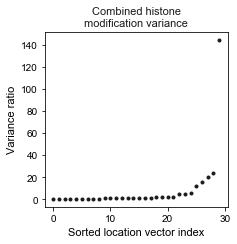

In [6]:
# Plot the sorted test statistic for the ANOVA analysis across assays.
fig = plt.figure(figsize=(3.4,3.5))
ax = fig.add_subplot(111)     
l1, = ax.plot(range(0,n_loc)[:30],np.sort(full_var_ratio)[-30:],'.k')
ax.set_xlabel('Sorted location vector index',fontsize=11)
ax.set_ylabel('Variance ratio',fontsize=11)
plt.title('Combined histone\nmodification variance',fontsize=11)
plt.tight_layout()

plt.savefig(output_dir + 'figures/' + 'figureS1_panels/' + file_prefix +
            '_panelB_combined_variance_ratio_' + date + '.pdf', format='pdf')

H3K27ac [ 8 12  1  4  3]
ANOVA p-value: 1.1102230246251565e-16
H3K4me3 [19 15 12 10  3]
ANOVA p-value: 8.408274076998623e-12
H3K4me1 [11 10  1  9  3]
ANOVA p-value: 6.439293542825908e-15


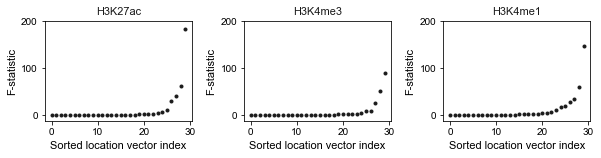

In [7]:
# Plot the sorted F-statistic for the ANOVA analysis for each assay.
f, axes = plt.subplots(1, len(assay_name), figsize=((8.45/3)*len(assay_name), 2.3))
for k, axis in zip(range(len(assay_name)), axes):
    l1, = axis.plot(np.sort(bGroupVar[k,:]/(wGroupVar[k,:]/(n_pt*n_gr - n_gr)))[-30:],'.k')
    axis.set_xlabel('Sorted location vector index',fontsize=11)
    axis.set_ylabel('F-statistic',fontsize=11)
    axis.set_title(assay_name[k],fontsize=11)
    axis.set_ylim(-12, 200)
plt.tight_layout()

plt.savefig(output_dir + 'figures/' + 'figureS1_panels/' + file_prefix +
            '_panelCDE_individual_variance_ratio_' + date + '.pdf', format='pdf')

for k in range(n_as):
    print(assay_name[k], np.argsort(bGroupVar[k,:]/(wGroupVar[k,:]/(n_pt*n_gr - n_gr)))[-5:])
    print("ANOVA p-value:" , 1 - scipy.stats.f.cdf(np.max(bGroupVar[k,:]/(wGroupVar[k,:]/(n_pt*n_gr - n_gr))),
                             (n_gr-1), n_gr*(n_pt-1),
                             loc=0, scale=1))

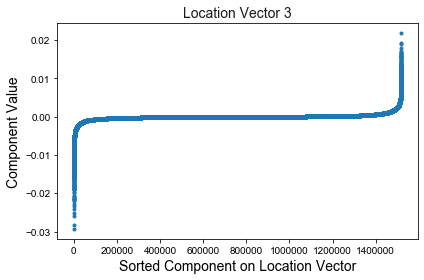

In [8]:
# Plot the sorted location vector for the mode with the
# greatest between group separation.
fig = plt.figure()
ax = fig.add_subplot(111)     
l1, = ax.plot(np.sort(U_l[:,np.argmax(full_var_ratio)]),'.')
ax.set_xlabel('Sorted Component on Location Vector',fontsize=14)
ax.set_ylabel('Component Value',fontsize=14)
plt.title('Location Vector ' + str(np.argmax(full_var_ratio)),fontsize=14)
plt.tight_layout()
#plt.close()

In [9]:
# Get the bins (location vector components representing genomic regions)
# that are significantly non-zero for the location vector that separates
# the conditions.

# Select the mode with greatest between condition separation.
l = np.argmax(full_var_ratio)

# Set the threshold for a vector component to be considered significant.
# The empirical distribution of component values from all vectors is used
# to set the threshold.

cut = np.percentile(np.absolute(U_l), 99.9, interpolation='nearest')

significant_pos = []
significant_neg = []
for i in range(L_genome):
    if(U_l[i,l] > cut):
        significant_pos.append(i)
    elif(U_l[i,l] < -cut):
        significant_neg.append(i)
        
print(len(significant_pos), 'positive')
print(len(significant_neg), 'negative')

1306 positive
1818 negative


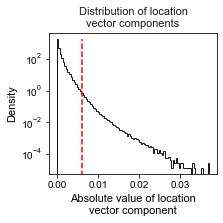

In [10]:
# Figure S1B (distribution of vector components)
# Get the distribution of all location vector components.

fig = plt.figure(figsize=(3.21, 3.2))

ax = fig.add_subplot(111)     

n, bins, patches = ax.hist(np.abs(U_l.flatten()), 100, density=True,
                            histtype='step', cumulative=False, color='k')

ax.plot([cut, cut], [0,max(n)], '--', linewidth=1.5, c=(1,0,0,1))

ax.set_xlabel('Absolute value of location\nvector component',fontsize=11)
ax.set_ylabel('Density',fontsize=11)
ax.set_yscale("log")
plt.title('Distribution of location\nvector components',fontsize=11)
plt.tight_layout()

plt.savefig(output_dir + 'figures/' + 'figureS1_panels/' + file_prefix +
            '_panelF_location_vector_component_distribution_' + date + '.pdf', format='pdf')

In [11]:
### Classification analysis using the projections ###

In [12]:
def parallelPC1(X,clf):
    N, L = X.shape
    Z = np.zeros_like(X)
    w = clf.coef_[0]
    b = clf.intercept_[0]
    for i in range(N):
        Z[i] = X[i] - (np.dot(X[i],w)/np.dot(w,w))*w
    pca = sklearn.decomposition.PCA(n_components=1, copy=True)
    PC_proj = pca.fit_transform(Z)
    return PC_proj[:,0], pca

def additionalDataPC1(pca, clf, X_add):
    N = len(X_add)
    Z_add = np.zeros_like(X_add)
    w = clf.coef_[0]
    for i in range(N):
        Z_add[i] = X_add[i] - (np.dot(X_add[i],w)/np.dot(w,w))*w
    return pca.transform(Z_add)

In [13]:
def T_Product(m_X,m_w0,m_w1):
    T_Prod=np.dot(np.dot(m_X,m_w1),m_w0);
    return T_Prod;

def PredictValue(m_X,m_w0,m_w1,m_b):
    T_Predval=np.dot(np.dot(m_X,m_w1),m_w0)+m_b;
    return T_Predval;

def Predict(m_X,m_w0,m_w1,m_b):
    T_predval=np.dot(np.dot(m_X,m_w1),m_w0)+m_b;
    T_Pred=-1;
    if (T_predval>=0): T_Pred=1;
    return T_Pred;
    
def Contstraint(m_X,m_w0,m_w1,m_b):    
    T_Contstraint=np.dot(np.dot(m_X,m_w1),m_w0)+m_b;
    return T_Contstraint;

def LossFunction(X_vec,Y_vec,m_w0,m_w1,m_b,m_lambda1,m_lambda2):    
    LF=0.5*m_lambda1*np.dot(m_w0,m_w0)*np.dot(m_w1,m_w1)+0.25*m_lambda2*np.dot(m_w0,m_w0)*np.dot(m_w0,m_w0)+0.25*m_lambda2*np.dot(m_w1,m_w1)*np.dot(m_w1,m_w1);
    for i in range(len(X_vec)): LF=LF+max(0,-(Y_vec[i]*Contstraint(X_vec[i],m_w0,m_w1,m_b)-1));
    return LF;

def TrainSTM(alpha,Lambda1,Lambda2,X_T,Y_T,w0_I,w1_I,b_I):

    #initialize Parametres    
    [Fixed_w0_Flag,Fixed_w1_Flag]=[False,False];
    [w0,w1,b]=[w0_I,w1_I,b_I];
    [X,Y]=[X_T,Y_T];


    N_Epochs=400; #number of epochs
    N_SubEpochs=250; #number of epochs
    
    if (Fixed_w0_Flag): w0=np.array([1.0,0,0]);
    if (Fixed_w1_Flag): w1=np.array([1.0,0,0,0,0,0,0,0,0,0]);

    AccuracyDict=defaultdict(lambda:0,Counter([Y[i]==Predict(X[i],w0,w1,b) for i in range(len(X))]));
    Accuracy=AccuracyDict[True]/float(AccuracyDict[True]+AccuracyDict[False]);
    [w0_history,w1_history,b_history,LF_history,Accuracy_history]=[[w0],[w1],[b],[LossFunction(X,Y,w0,w1,b,Lambda1,Lambda2)],[Accuracy]];
    for n in range(N_Epochs):
        #print(str(n))

        #update rule
        #do minimization in turn
        if (not Fixed_w0_Flag):
            for n_s in range(N_SubEpochs):
                for i in range(len(X)): 
                    if(Y[i]*Contstraint(X[i],w0,w1,b)<1): w0=w0+alpha*(Y[i]*np.dot(X[i],w1)-Lambda1*np.dot(w1,w1)*w0-Lambda2*np.dot(w0,w0)*w0);
                    else: w0=w0-alpha*(Lambda1*np.dot(w1,w1)*w0+Lambda2*np.dot(w0,w0)*w0);   
                for i in range(len(X)):
                    if(Y[i]*Contstraint(X[i],w0,w1,b)<1): b=b+alpha*(Y[i]); 
                    else: continue;
        
        if (not Fixed_w1_Flag):    
            for n_s in range(N_SubEpochs):              
                for i in range(len(X)): 
                    if(Y[i]*Contstraint(X[i],w0,w1,b)<1): w1=w1+alpha*(Y[i]*np.dot(w0,X[i])-Lambda1*np.dot(w0,w0)*w1-Lambda2*np.dot(w1,w1)*w1);
                    else: w1=w1-alpha*(Lambda1*np.dot(w0,w0)*w1+Lambda2*np.dot(w1,w1)*w1);   
                for i in range(len(X)):
                    if(Y[i]*Contstraint(X[i],w0,w1,b)<1): b=b+alpha*(Y[i]); 
                    else: continue;
    
    
        AccuracyDict=defaultdict(lambda:0,Counter([Y[i]==Predict(X[i],w0,w1,b) for i in range(len(X))]));
        Accuracy=AccuracyDict[True]/float(AccuracyDict[True]+AccuracyDict[False]);
        [w0_history.append(w0),w1_history.append(w1),b_history.append(b),LF_history.append(LossFunction(X,Y,w0,w1,b,Lambda1,Lambda2)),Accuracy_history.append(Accuracy)];
        #print(str(np.linalg.norm(w0-w0_history[n]))+'\t'+str(np.linalg.norm(w1-w1_history[n]))+'\t'+str(np.abs(b-b_history[n]))+'\t'+str(LossFunction(X,Y,w0,w1,b,Lambda1,Lambda2)));  

    return [w0_history,w1_history,b_history,LF_history,Accuracy_history]; 

In [14]:
# Process the data sets for use in the classifiers.
print("Number of projections to be used for classificiation: {}".format(n_proj))
norm_sample_proj = np.zeros_like(sample_proj[:,:,:,:n_proj])
for k in range(n_as):
    for j in range(n_pt):
        for i in range(n_gr):
            norm_sample_proj[i,j,k,:] = sample_proj[i,j,k,:n_proj]/np.linalg.norm(sample_proj[i,j,k,:n_proj], ord=2)
# Matrix variable for STM.
X_STM = np.reshape(norm_sample_proj, (n_gr*n_pt, n_as, n_proj),  order='C')

# Flatten data into a vector for SVM.
X = np.reshape(norm_sample_proj, (n_gr*n_pt, n_as*n_proj),  order='C')
Y = np.concatenate((-np.ones(n_pt,dtype=np.int), np.ones(n_pt,dtype=np.int)))

additional_test_file = open(input_dir + file_prefix + '_additional_pt_projections.txt','r')
add_index = []
add_projections_list = []
for line in additional_test_file:
    l = line.strip().split(':')
    add_index.append([int(l[0].split(',')[0]), int(l[0].split(',')[1])])
    add_projections_list.append(l[1].strip().split(','))

additional_projections = np.zeros((7,3,n_proj))
for i, ind in enumerate(add_index):
        additional_projections[ind[0],ind[1]] = add_projections_list[i][:n_proj]

additional_test_file.close()
    
for j in range(len(additional_projections)):
    for k in range(len(additional_projections[0])):
        additional_projections[j,k] = additional_projections[j,k,:n_proj]/np.linalg.norm(additional_projections[j,k,:n_proj])
        
X_additional = np.reshape(additional_projections, (len(additional_projections), n_as*n_proj), order='C')

Number of projections to be used for classificiation: 10


[2.32827494 1.32265735 2.37648962] [ 2.28418917 -0.92716487  0.41442376 -2.23078213 -0.35716977 -0.41934355
 -0.15354835  0.06596472  1.5645705   0.85086362] -12.742238515408197
(1, 30)
Training accuracy:  1.0
Test accuracy:  1.0


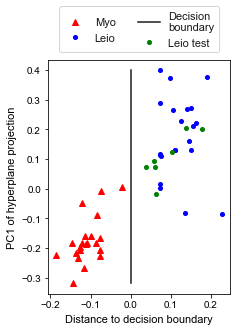

In [15]:
# Figure 2C (STM classifier)

# Set STM parameters.
alpha=0.0001; #learning rate
Lambda2=0.0; #regularization
Lambda1=0.0005; #regularization
Scale=0.1

# Initial STM parameters to be fit.
w0_init=Scale*np.random.rand(n_as);
w1_init=Scale*np.random.rand(n_proj);
b_init=Scale*np.random.rand(1)[0]
# Fit STM parameters.
[w0_history,w1_history,b_history,LF_history,Accuracy_history]=TrainSTM(alpha,Lambda1,Lambda2,X_STM,Y,w0_init,w1_init,b_init);
[w0,w1,b,LF,Accuracy]=[w0_history[-1],w1_history[-1],b_history[-1],LF_history[-1],Accuracy_history[-1]];

print(w0, w1, b)

# Format and store the STM parameters as an sklearn SVM
# object for the purpose of computing the distance to
# the hyperplane and PCA.
clf = svm.LinearSVC(C=1.0, max_iter=10000 ,tol=1e-5, class_weight='balanced', penalty='l2', loss='squared_hinge')
clf.coef_ = np.reshape(np.outer(w0, w1).flatten(order='C'),(-1,n_as*n_proj))
clf.intercept_ = [b]
clf.classes_ = np.array([-1, 1])
print(clf.coef_.shape)
print("Training accuracy: ", clf.score(X, Y))
print("Test accuracy: ", clf.score(X_additional,np.ones(7)))

X_distToHyperplane = clf.decision_function(X)/np.linalg.norm(clf.coef_, ord=2)
parallel_pc1, pca = parallelPC1(X,clf)
        
additional_distToHyperplane = clf.decision_function(X_additional)/np.linalg.norm(clf.coef_, ord=2)
additional_PC = additionalDataPC1(pca, clf, X_additional)

fig = plt.figure(figsize=(3.4,4.8))
ax = fig.add_subplot(111)    

l1, = ax.plot(X_distToHyperplane[:n_pt], parallel_pc1[:n_pt], '^', c=(1,0,0,1))
l2, = ax.plot(X_distToHyperplane[n_pt:], parallel_pc1[n_pt:], '.',c=(0,0,1,1),markersize=8)
l3, = ax.plot([0,0],[min(parallel_pc1),max(parallel_pc1)],'k')
l4, = ax.plot(additional_distToHyperplane, additional_PC,'.',c=(0,0.5,0,1),markersize=8)

ax.legend([l1, l2, l3, l4], ["Myo", "Leio", "Decision\nboundary", "Leio test"],
           loc='upper center', bbox_to_anchor=(0.5,1.25), ncol=2, fontsize=11)

ax.set_xlabel('Distance to decision boundary',fontsize=11)
ax.set_ylabel('PC1 of hyperplane projection',fontsize=11)
plt.tight_layout()

plt.savefig(output_dir + 'figures/' + 'figure2_panels/' + file_prefix +
            '_panelC_projectionOfDecisionBoundary_STM_' + date + '.pdf', bbox_inches='tight', format='pdf')

Training accuracy:  1.0
Test accuracy:  1.0


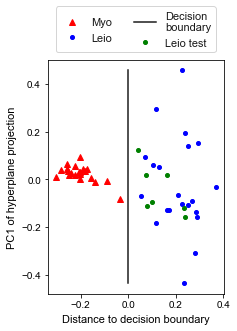

In [16]:
# SVM classification using all histone modifications.

clf = svm.LinearSVC(C=1.0, max_iter=10000 ,tol=1e-5, class_weight='balanced', penalty='l2', loss='squared_hinge')
clf.fit(X,Y)
print("Training accuracy: ", clf.score(X,Y))
print("Test accuracy: ", clf.score(X_additional,np.ones(7)))

X_distToHyperplane = clf.decision_function(X)/np.linalg.norm(clf.coef_, ord=2)
parallel_pc1, pca = parallelPC1(X,clf)
        
additional_distToHyperplane = clf.decision_function(X_additional)/np.linalg.norm(clf.coef_, ord=2)
additional_PC = additionalDataPC1(pca, clf, X_additional)

fig = plt.figure(figsize=(3.4,4.8))
ax = fig.add_subplot(111)    

l1, = ax.plot(X_distToHyperplane[:n_pt], parallel_pc1[:n_pt], '^', c=(1,0,0,1))
l2, = ax.plot(X_distToHyperplane[n_pt:], parallel_pc1[n_pt:], '.',c=(0,0,1,1),markersize=8)
l3, = ax.plot([0,0],[min(parallel_pc1),max(parallel_pc1)],'k')
l4, = ax.plot(additional_distToHyperplane,additional_PC,'.',c=(0,0.5,0,1),markersize=8)

ax.legend([l1, l2, l3, l4], ["Myo", "Leio", "Decision\nboundary", "Leio test"],
           loc='upper center', bbox_to_anchor=(0.5,1.25), ncol=2, fontsize=11)

ax.set_xlabel('Distance to decision boundary',fontsize=11)
ax.set_ylabel('PC1 of hyperplane projection',fontsize=11)
plt.tight_layout()

Trianing accuracy, H3K27ac: 1.0
Test accuracy, H3K27ac: 1.0
Trianing accuracy, H3K4me3: 0.9523809523809523
Test accuracy, H3K4me3: 0.8571428571428571
Trianing accuracy, H3K4me1: 0.9761904761904762
Test accuracy, H3K4me1: 1.0


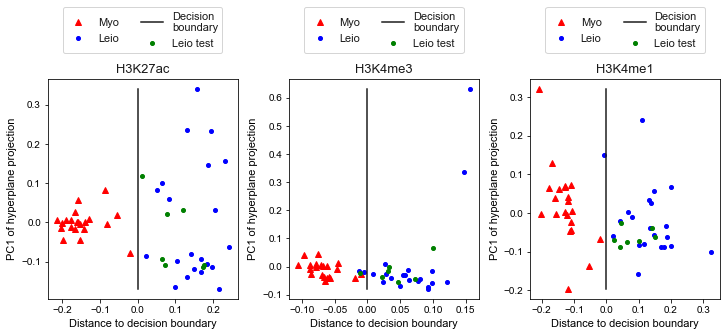

In [17]:
# SVM classification for each histone modification separately.

f, axes = plt.subplots(1, n_as, figsize=(3.4*n_as, 4.8))

for k, axis in zip(range(n_as), axes):
    X_single = np.reshape(norm_sample_proj[:,:,k,:n_proj], (n_gr*n_pt,n_proj), order='C')    
    clf = svm.LinearSVC(C=1.0, max_iter=10000 ,tol=1e-5, class_weight='balanced', penalty='l2', loss='squared_hinge')
    clf.fit(X_single, Y)
    print("Trianing accuracy, {}: {}".format(assay_name[k], clf.score(X_single, Y)))
    X_distToHyperplane = clf.decision_function(X_single)/np.linalg.norm(clf.coef_, ord=2)
    parallel_pc1, pca = parallelPC1(X_single, clf)
    
    X_add_single = np.copy(additional_projections[:,k,:n_proj])
            
    additional_distToHyperplane = clf.decision_function(X_add_single)/np.linalg.norm(clf.coef_, ord=2)
    additional_PC = additionalDataPC1(pca, clf, X_add_single) 
    
    print("Test accuracy, {}: {}".format(assay_name[k], clf.score(X_add_single, np.ones(7))))
    l1, = axis.plot(X_distToHyperplane[:n_pt], parallel_pc1[:n_pt], '^', c=(1,0,0,1))
    l2, = axis.plot(X_distToHyperplane[n_pt:], parallel_pc1[n_pt:], '.',c=(0,0,1,1),markersize=8)
    l3, = axis.plot([0,0],[min(parallel_pc1),max(parallel_pc1)],'k')
    l4, = axis.plot(additional_distToHyperplane,additional_PC,'.',c=(0,0.5,0,1),markersize=8)
        
    axis.legend([l1, l2, l3, l4], ["Myo", "Leio", "Decision\nboundary", "Leio test"],
                loc='upper center', bbox_to_anchor=(0.5,1.35), ncol=2, fontsize=11)

    axis.set_xlabel('Distance to decision boundary',fontsize=11)
    axis.set_ylabel('PC1 of hyperplane projection',fontsize=11)
    axis.set_title(assay_name[k], fontsize=13)
    plt.tight_layout()

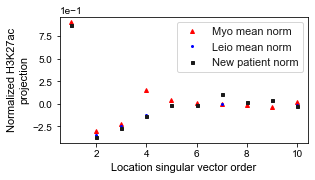

In [18]:
# Figure 2B (Projection of new patient)
# Load in data for an additional patient not used in 
# the data tensor. Project onto the location vectors
# and scale the first 10 projections to unit l2 norm.
add_pt_data = torch.load(input_dir + file_prefix + '_additional_pt_tensor.pt', map_location='cpu').numpy()[0,0,:]
add_pt_proj = X_additional[0,:10]
add_pt_proj /= np.linalg.norm(add_pt_proj,ord=2)

fig = plt.figure(figsize=(4.286,6.83))
assay = 0

x = [j+1 for j in range(0,len(projections[0]))]
ax = fig.add_subplot(311)

l1, = ax.plot(np.mean(norm_sample_proj[0,:,assay,:], axis=0), '^', c=(1,0,0,1), markersize=4)
l2, = ax.plot(np.mean(norm_sample_proj[1,:,assay,:], axis=0), '.', c=(0,0,1,1), markersize=4)
l3, = ax.plot(add_pt_proj,'ks' ,markersize=3)

ax.legend([l1, l2, l3], ["Myo mean norm", "Leio mean norm", "New patient norm"],fontsize=11)
ax.set_ylabel('Normalized H3K27ac\nprojection',fontsize=11)
ax.set_xlabel('Location singular vector order',fontsize=11)
plt.ticklabel_format(axis='y',style='plain',scilimits=(0,1))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0.0,0.0))
plt.xticks([2*i+1 for i in range(int(n_proj/2))], [2*(i+1) for i in range(int(n_proj/2))])
plt.tight_layout()

plt.savefig(output_dir + 'figures/' + 'figure2_panels/' + file_prefix +
            '_panelB_project_new_sample_' + date + '.pdf', bbox_inches='tight', format='pdf')

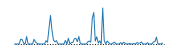

In [19]:
# This is used for making the projection schematic shown
# in Figure 2B. 
fig = plt.figure(figsize=(2.58,0.85))
ax = fig.add_subplot(111)  
ax.plot([0,100],[0,0],'k:',linewidth=1.0)
l1, = ax.plot([i for i in range(0,100)],add_pt_data[415:515],linewidth=1.0)
ax.axis('off')
plt.tight_layout()
plt.savefig(output_dir + 'figures/' + 'figure2_panels/' + file_prefix +
            '_panelB_pt_example_' + date + '.pdf', bbox_inches='tight', format='pdf')

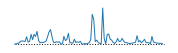

In [20]:
# This is used for making the projection schematic shown
# in Figure 2B. 
fig = plt.figure(figsize=(2.58,0.85))
ax = fig.add_subplot(111)  
ax.plot([0,100],[0,0],'k:',linewidth=1.0)
l1, = ax.plot([i for i in range(0,100)],U_l[415:515, 0],linewidth=1.0)
ax.axis('off')
plt.tight_layout()
plt.savefig(output_dir + 'figures/' + 'figure2_panels/' + file_prefix +
            '_panelB_loc_vec_0_' + date + '.pdf', bbox_inches='tight', format='pdf')

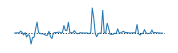

In [21]:
# This is used for making the projection schematic shown
# in Figure 2B. 
fig = plt.figure(figsize=(2.58,0.85))
ax = fig.add_subplot(111)  
ax.plot([0,100],[0,0],'k:',linewidth=1.0)
l1, = ax.plot([i for i in range(0,100)],U_l[415:515, 1],linewidth=1.0) 
ax.axis('off')
plt.tight_layout()
plt.savefig(output_dir + 'figures/' + 'figure2_panels/' + file_prefix +
            '_panelB_loc_vec_1_' + date + '.pdf', bbox_inches='tight', format='pdf')

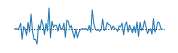

In [22]:
# This is used for making the projection schematic shown
# in Figure 2B. 
fig = plt.figure(figsize=(2.58,0.85))
ax = fig.add_subplot(111)  
ax.plot([0,100],[0,0],'k:',linewidth=1.0)
l1, = ax.plot([i for i in range(0,100)],U_l[415:515, -1],linewidth=1.0)
ax.axis('off')
plt.tight_layout()
plt.savefig(output_dir + 'figures/' + 'figure2_panels/' + file_prefix +
            '_panelB_loc_vec_126_' + date + '.pdf', bbox_inches='tight', format='pdf')

In [23]:
# The genomic bins used for the hg19 genome. chrY is 
# removed from the data before the HOSVD. Since chrY is
# at the end of the chromosome list used, this is
# not a problem.
chr_list = abf.getChrList()
chr_length = {'chrY': 59373566, 'chrX': 155270560, 'chr13': 115169878,
              'chr12': 133851895, 'chr11': 135006516, 'chr10': 135534747,
              'chr17': 81195210, 'chr16': 90354753, 'chr15': 102531392,
              'chr14': 107349540, 'chr19': 59128983, 'chr18': 78077248,
              'chrM': 16571, 'chr22': 51304566, 'chr20': 63025520,
              'chr21': 48129895, 'chr7': 159138663, 'chr6': 171115067,
              'chr5': 180915260, 'chr4': 191154276, 'chr3': 198022430,
              'chr2': 243199373, 'chr1': 249250621, 'chr9': 141213431,
              'chr8': 146364022}
bin_size = 2000

genomic_bin = [[] for l in range(0,1547874)]
counter = 0
for chrom in chr_list:
    for l in range(0, int(np.ceil(chr_length[chrom]/bin_size))+1):
        genomic_bin[counter] = [chrom, l*bin_size, (l+1)*bin_size]
        counter += 1
print(genomic_bin[72537])
print(counter)

['chr1', 145074000, 145076000]
1547874


In [24]:
# Save the regions exhibiting epigenetic alterations 
# between leiomyoma and myometrium. 1-based indexing
# is used for the file names.

output_pos = open(output_dir + 'region_files/' + file_prefix + '_pos_loc' + str(np.argmax(full_var_ratio)+1) + '.txt','w+')

for l in range(0,len(significant_pos)):
            output_pos.write('{}\t{}\t{}\n'.format(genomic_bin[significant_pos[l]][0], genomic_bin[significant_pos[l]][1], genomic_bin[significant_pos[l]][2]))     
output_pos.close()

output_neg = open(output_dir + 'region_files/' + file_prefix + '_neg_loc' + str(np.argmax(full_var_ratio)+1) + '.txt','w+')

for l in range(0,len(significant_neg)):
            output_neg.write('{}\t{}\t{}\n'.format(genomic_bin[significant_neg[l]][0], genomic_bin[significant_neg[l]][1], genomic_bin[significant_neg[l]][2]))
output_neg.close()

In [25]:
### Some additional files are useful for functional annotation studies
### or motif calling. These are generated here.

# Read in the ATACseq peaks as a bed array. Get the union of these peaks.
# This will be used to intersect with the identified regions to look for 
# motifs in open chromatin regions that are enriched for one set or the other.
merged_ATAC_bed = abf.readBed(input_dir + 'ATACseq_concatenated_peaks.narrowPeak')
all_ATAC_regions = abf.unionOfRegions(merged_ATAC_bed, 0)

# Specify the significant regions generated in the frames above.
sig_pos_file = output_dir + 'region_files/' + file_prefix + '_pos_loc' + str(np.argmax(full_var_ratio)+1) + '.txt'
sig_neg_file = output_dir + 'region_files/' + file_prefix + '_neg_loc' + str(np.argmax(full_var_ratio)+1) + '.txt'

# Merge neighboring significant regions and write these.
sig_bed_pos = abf.unionOfRegions(abf.readBed(sig_pos_file),0)
sig_bed_neg = abf.unionOfRegions(abf.readBed(sig_neg_file),0)

merged_pos_out = output_dir + 'region_files/' + file_prefix + '_merged_pos_loc' + str(np.argmax(full_var_ratio)+1) + '.txt'
merged_neg_out = output_dir + 'region_files/' + file_prefix + '_merged_neg_loc' + str(np.argmax(full_var_ratio)+1) + '.txt'

abf.writeBed(sig_bed_pos, merged_pos_out)
abf.writeBed(sig_bed_neg, merged_neg_out)

# Intersect the merged significant regions with the merged ATAC-seq
# peak regions and save the resulting regions.
intersect_pos_out_ATACseq = open(output_dir + 'region_files/' + file_prefix + '_ATACseq_intersect_pos_loc' + str(np.argmax(full_var_ratio)+1) + '_' + date + '.txt', 'w+')
intersect_neg_out_ATACseq = open(output_dir + 'region_files/' + file_prefix + '_ATACseq_intersect_neg_loc' + str(np.argmax(full_var_ratio)+1) + '_' + date + '.txt', 'w+')

intersect_ATACseq_pos = abf.intersectBed(sig_bed_pos, all_ATAC_regions) 
intersect_ATACseq_neg = abf.intersectBed(sig_bed_neg, all_ATAC_regions)

# Only save those regions that are at least 25bp in length.
for c, chrom in enumerate(chr_list):
    for l in range(len(intersect_ATACseq_pos[c])):
        if(intersect_ATACseq_pos[c][l][2] - intersect_ATACseq_pos[c][l][1] >= 25):
            intersect_pos_out_ATACseq.write("{}\t{}\t{}\n".format(intersect_ATACseq_pos[c][l][0], intersect_ATACseq_pos[c][l][1], intersect_ATACseq_pos[c][l][2]))
    for l in range(len(intersect_ATACseq_neg[c])):
        if(intersect_ATACseq_neg[c][l][2] - intersect_ATACseq_neg[c][l][1] >= 25):
            intersect_neg_out_ATACseq.write("{}\t{}\t{}\n".format(intersect_ATACseq_neg[c][l][0], intersect_ATACseq_neg[c][l][1], intersect_ATACseq_neg[c][l][2]))

intersect_pos_out_ATACseq.close()
intersect_neg_out_ATACseq.close()

# Create a bedgraph of the differential vector signal.
locvec_bedgraph = open(output_dir + 'region_files/' + file_prefix + '_location_vec4.bedgraph','w+')
locvec_bedgraph.write('browser position chr19:49302001-49304701\n')
locvec_bedgraph.write('track type=bedGraph name="loc4 values" description="HOSVD location vector 4 values" visibility=full color=180,0,0 altColor=0,0,180 priority=20\n')
for l in range(L_genome):
    if(genomic_bin[l][2] <= chr_length[genomic_bin[l][0]]):
        locvec_bedgraph.write("{}\t{}\t{}\t{}\n".format(genomic_bin[l][0], genomic_bin[l][1], genomic_bin[l][2], U_l[l,3]))
locvec_bedgraph.close()

In [26]:
## Repeat the analysis for comparing MED12-mut and MED12-wt leiomyoma ##

In [27]:
# List of patients whose tumors have mutations in exon 2 of MED12.
MED12mut_list = [0, 2, 3, 4, 6, 10, 11, 12, 14, 15, 17, 18, 20]
MED12wt_list = []
for j in range(n_pt):
    if(j not in MED12mut_list):
        MED12wt_list.append(j)

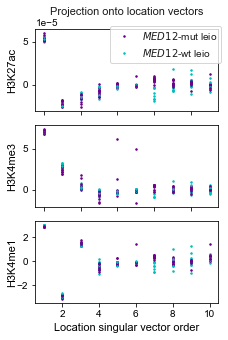

In [28]:
fig = plt.figure(figsize=(3.27087,4.82))
n_proj = 10
assay_name = ['H3K27ac', 'H3K4me3', 'H3K4me1']
ax = []
for k in range(n_as):
    assay = k
    ax.append(fig.add_subplot(311+k))
    for i in range(0,n_pt):
        if(i in MED12mut_list):
            l1, = ax[k].plot(sample_proj[1, i, assay][0:n_proj],'.', markersize=3, c=(110/255, 0/255, 140/255))
        else:
            l2, = ax[k].plot(sample_proj[1, i, assay][0:n_proj],'.', markersize=3, c=(0,0.75,0.75,1))
    
    if(k == 0):
        plt.title('Projection onto location vectors',fontsize=11,y=1.1)
        ax[k].legend([l1, l2], ["$\it{MED12}$-mut leio", "$\it{MED12}$-wt leio"], fontsize=10, bbox_to_anchor=(0.38,0.53))
        
    ax[k].set_ylabel(assay_name[k],fontsize=11)
    ax[k].get_yaxis().set_label_coords(-0.1,0.5)
    if(k == 0):
        plt.yticks([0,5*10**-5])
    elif(k == 1):
        plt.yticks([0,5*10**-5])
    else:
        plt.yticks([-2*10**-5,0,2*10**-5])
    ax[k].ticklabel_format(axis='y', style='sci', scilimits=(0.0,0.0))
    if(k < n_as-1): 
        plt.setp(ax[k].get_xticklabels(), visible=False)
    if(k != 0):
        ax[k].yaxis.get_offset_text().set_visible(False)
    
    if(k == n_as-1):
        ax[k].set_xlabel('Location singular vector order',fontsize=11)
        plt.setp(ax[k].get_xticklabels(), visible=True)
        plt.xticks([2*i+1 for i in range(int(n_proj/2))], [2*(i+1) for i in range(int(n_proj/2))])

plt.tight_layout()

In [29]:
# ANOVA analysis to identify location vectors that separate the 
# tumors with MED12 mutation from those that do not.
full_var_ratio_MED12 = np.zeros(n_loc)
wGroupVar_MED12 = np.zeros((n_as, n_loc))
bGroupVar_MED12 = np.zeros((n_as, n_loc))

for l in range(n_loc):
    for k in range(n_as):
        bGroupVar_MED12[k,l] = len(MED12mut_list)*(np.mean(sample_proj[1,MED12mut_list,k,l]) - np.mean((sample_proj[1,:,k,l])))**2 +\
                               len(MED12wt_list)*(np.mean(sample_proj[1,MED12wt_list,k,l]) - np.mean((sample_proj[1,:,k,l])))**2
        wGroupVar_MED12[k,l] = sum( np.power(sample_proj[1,MED12mut_list,k,l] - np.mean(sample_proj[1,MED12mut_list,k,l]),2) ) +\
                               sum( np.power(sample_proj[1,MED12wt_list,k,l] - np.mean(sample_proj[1,MED12wt_list,k,l]),2) )
        
        full_var_ratio_MED12[l] = (sum(bGroupVar_MED12[:,l])/(n_as*(2-1)))/(sum(wGroupVar_MED12[:,l])/(n_as*(n_pt-2)))
            
print(np.argsort(full_var_ratio_MED12)[-10:])
print(1 - scipy.stats.f.cdf(max(full_var_ratio_MED12),
                            n_as*(2-1), n_as*(n_pt-2),
                            loc=0, scale=1))

[11 15 10 35 29  1 20 23 19  6]
1.1102230246251565e-16


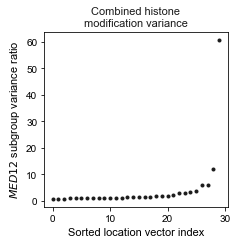

In [30]:
# Plot the sorted test statistic for the ANOVA analysis across assays.
fig = plt.figure(figsize=(3.4,3.5))
ax = fig.add_subplot(111)     
l1, = ax.plot(np.sort(full_var_ratio_MED12)[-30:],'.k')
ax.set_xlabel('Sorted location vector index',fontsize=11)
ax.set_ylabel('$\it{MED12}$ subgroup variance ratio',fontsize=11)
plt.title('Combined histone\nmodification variance',fontsize=11)
plt.tight_layout()

H3K27ac [35 29  4 20  6]
1.1469850835776896e-07
H3K4me3 [11 20 23 19  6]
1.8088310201891389e-06
H3K4me1 [15 10 19  0  6]
2.9963890579853825e-07


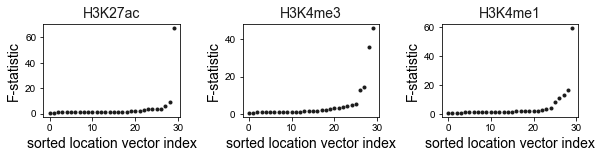

In [31]:
# Plot the sorted F-statistic for the ANOVA analysis for each assay.
f, axes = plt.subplots(1, len(assay_name), figsize=((8.45/3)*len(assay_name), 2.3))
for k, axis in zip(range(len(assay_name)), axes):
    l1, = axis.plot(np.sort(bGroupVar_MED12[k,:]/(wGroupVar_MED12[k,:]/(n_pt - n_gr)))[-30:],'.k')
    axis.set_xlabel('sorted location vector index',fontsize=14)
    axis.set_ylabel('F-statistic',fontsize=14)
    axis.set_title(assay_name[k],fontsize=14)
plt.tight_layout()

for k in range(n_as):
    print(assay_name[k], np.argsort(bGroupVar_MED12[k,:]/(wGroupVar_MED12[k,:]/(n_pt - 2)))[-5:])
    print(1 - scipy.stats.f.cdf(np.max(bGroupVar_MED12[k,:]/(wGroupVar_MED12[k,:]/(n_pt - 2))),
                        (2-1), n_pt-2,
                        loc=0, scale=1))

In [32]:
# Test for the equality of the variance of myometrium
# and leiomyoma samples using Levene's test.
for k in range(n_as):
    print(assay_name[k], scipy.stats.levene(sample_proj[0,:,k,6],
                                            sample_proj[1,:,k,6], center='mean'))

H3K27ac LeveneResult(statistic=44.032904246759166, pvalue=6.05048704224697e-08)
H3K4me3 LeveneResult(statistic=47.88727412127271, pvalue=2.423625488100979e-08)
H3K4me1 LeveneResult(statistic=35.339249625978, pvalue=5.653486054626239e-07)


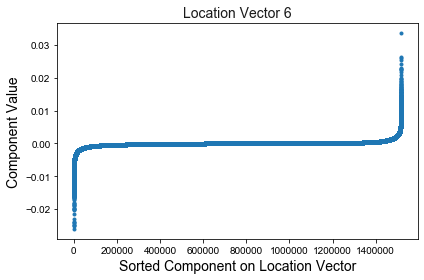

In [33]:
# Plot the sorted location vector for the mode with the
# greatest between group separation.
fig = plt.figure()
ax = fig.add_subplot(111)     
l1, = ax.plot(np.sort(U_l[:,np.argmax(full_var_ratio_MED12)]),'.')
ax.set_xlabel('Sorted Component on Location Vector',fontsize=14)
ax.set_ylabel('Component Value',fontsize=14)
plt.title('Location Vector ' + str(np.argmax(full_var_ratio_MED12)),fontsize=14)
plt.tight_layout()

In [34]:
# Get the bins (location vector components representing genomic regions)
# that are significantly non-zero for the location vector that separates
# MED12-mut and MED12-wt leiomyomas.

# Select the mode with greatest between tumor type separation.
l = np.argmax(full_var_ratio_MED12)

significant_pos_MED12 = []
significant_neg_MED12 = []
for i in range(L_genome):
    if(U_l[i,l] > cut):
        significant_pos_MED12.append(i)
    elif(U_l[i,l] < -cut):
        significant_neg_MED12.append(i)
        
print(len(significant_pos_MED12), 'positive')
print(len(significant_neg_MED12), 'negative')

1662 positive
1576 negative


In [35]:
# Save the regions that separate the tumor types.
output_pos = open(output_dir + 'region_files/' + file_prefix + '_pos_loc' + str(np.argmax(full_var_ratio_MED12)+1) + '_MED12.txt','w+')

for l in range(0,len(significant_pos_MED12)):
            output_pos.write('{}\t{}\t{}\n'.format(genomic_bin[significant_pos_MED12[l]][0], genomic_bin[significant_pos_MED12[l]][1], genomic_bin[significant_pos_MED12[l]][2]))     
output_pos.close()

output_neg = open(output_dir + 'region_files/' + file_prefix + '_neg_loc' + str(np.argmax(full_var_ratio_MED12)+1) + '_MED12.txt','w+')

for l in range(0,len(significant_neg_MED12)):
            output_neg.write('{}\t{}\t{}\n'.format(genomic_bin[significant_neg_MED12[l]][0], genomic_bin[significant_neg_MED12[l]][1], genomic_bin[significant_neg_MED12[l]][2]))
output_neg.close()

In [36]:
## Classification of leiomyoma subtypes analysis ##

In [37]:
# Process the projections for the MED12 classification.

X_MED12_STM = np.reshape(norm_sample_proj[1,:,:,:], (n_pt, n_as, n_proj),  order='C')

X_MED12 = np.reshape(norm_sample_proj[1,:,:,:], (n_pt, n_as*n_proj), order='C')
Y_MED12 = np.array([-1 if j in MED12mut_list else 1 for j in range(n_pt)])

Training accuracy: 1.0
Test accuracy: 1.0


<Figure size 432x288 with 0 Axes>

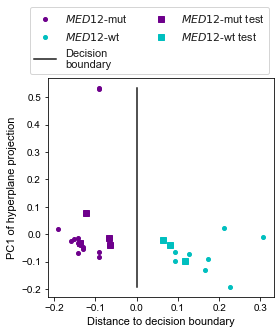

In [38]:
## Figure S3B (STM classification plot)

alpha=0.0001; #learning rate
Lambda2=0.0; #regularization
Lambda1=0.0005; #regularization
Scale=0.1

w0_init=Scale*np.random.rand(3);
w1_init=Scale*np.random.rand(10);
b_init=Scale*np.random.rand(1)[0]
    
[w0_history,w1_history,b_history,LF_history,Accuracy_history]=TrainSTM(alpha,Lambda1,Lambda2,X_MED12_STM,Y_MED12,w0_init,w1_init,b_init);
[w0,w1,b,LF,Accuracy]=[w0_history[-1],w1_history[-1],b_history[-1],LF_history[-1],Accuracy_history[-1]];

clf = svm.LinearSVC(C=1.0, max_iter=10000 ,tol=1e-5, class_weight='balanced', penalty='l2', loss='squared_hinge')
clf.coef_ = np.reshape(np.outer(w0, w1).flatten(),(-1,30))
clf.intercept_ = [b]
clf.classes_ = np.array([-1, 1])

print("Training accuracy: {}".format(clf.score(X_MED12, Y_MED12)))
print("Test accuracy: {}".format(clf.score(X_additional, np.array([-1, 1, 1, 1, -1, -1, -1]))))

X_distToHyperplane = clf.decision_function(X_MED12)/np.linalg.norm(clf.coef_, ord=2)
parallel_pc1, pca = parallelPC1(X_MED12, clf)
        
additional_distToHyperplane = clf.decision_function(X_additional)/np.linalg.norm(clf.coef_, ord=2)
additional_PC = additionalDataPC1(pca, clf, X_additional)

plt.clf()
fig = plt.figure(figsize=(4.0,5.0))
ax = fig.add_subplot(111)   


l1, = ax.plot([X_distToHyperplane[j] for j in MED12mut_list],
               [parallel_pc1[j] for j in MED12mut_list],
               '.', markersize=8, c = (110/255, 0/255, 140/255))
l2, = ax.plot([X_distToHyperplane[j] for j in MED12wt_list],
               [parallel_pc1[j] for j in MED12wt_list],
               '.', markersize=8, c = (0,0.75,0.75,1))
l3, = ax.plot([0,0],[min(parallel_pc1),max(parallel_pc1)],'k')

additional_MED12mut = [0, 4, 5, 6]
for i in range(len(X_additional)):
    if(i in additional_MED12mut):
        l4, = ax.plot(additional_distToHyperplane[i],additional_PC[i],'s', c=(110/255, 0/255, 140/255), markersize=6)
    else:
        l5, = ax.plot(additional_distToHyperplane[i],additional_PC[i],'s', c=(0,0.75,0.75,1), markersize=6)


ax.legend([l1, l2, l3, l4, l5], ["$\it{MED12}$-mut", "$\it{MED12}$-wt", "Decision\nboundary",
                                  "$\it{MED12}$-mut test", "$\it{MED12}$-wt test"],
           loc='upper center', bbox_to_anchor=(0.45,1.35), ncol=2, fontsize=11)

ax.set_xlabel('Distance to decision boundary',fontsize=11)
ax.set_ylabel('PC1 of hyperplane projection',fontsize=11)
plt.tight_layout()
plt.savefig(output_dir + 'figures/' + 'figureS3_panels/' + file_prefix +
            '_panelB_projection_classification_STM_' + date + '.pdf', bbox_inches='tight', format='pdf')

Training accuracy: 1.0
Test accuracy: 1.0


<Figure size 432x288 with 0 Axes>

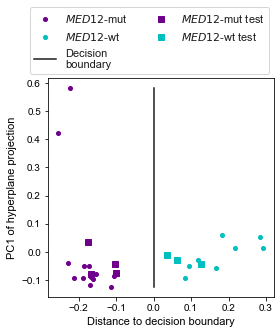

In [39]:
# SVM classification using all histone modifications.

clf = svm.LinearSVC(C=1.0, max_iter=10000 ,tol=1e-5, class_weight='balanced', penalty='l2', loss='squared_hinge')
clf.fit(X_MED12, Y_MED12)
print("Training accuracy: {}".format(clf.score(X_MED12, Y_MED12)))

X_distToHyperplane = clf.decision_function(X_MED12)/np.linalg.norm(clf.coef_, ord=2)
parallel_pc1, pca = parallelPC1(X_MED12, clf)

additional_MED12mut = [0, 4, 5, 6]
print("Test accuracy: {}".format(clf.score(X_additional, np.array([-1, 1, 1, 1, -1, -1, -1]))))

additional_distToHyperplane = clf.decision_function(X_additional)/np.linalg.norm(clf.coef_, ord=2)
additional_PC = additionalDataPC1(pca, clf, X_additional)

plt.clf()
fig = plt.figure(figsize=(4.0, 5.0))
ax = fig.add_subplot(111)   

l1, = ax.plot([X_distToHyperplane[j] for j in MED12mut_list],[parallel_pc1[j] for j in MED12mut_list],'.',markersize=8, c=(110/255, 0/255, 140/255))
l2, = ax.plot([X_distToHyperplane[j] for j in MED12wt_list],[parallel_pc1[j] for j in MED12wt_list],'.',markersize=8, c=(0,0.75,0.75,1))
l3, = ax.plot([0,0],[min(parallel_pc1),max(parallel_pc1)],'k')
for i in range(len(X_additional)):
    if(i in additional_MED12mut):
        l4, = ax.plot(additional_distToHyperplane[i],additional_PC[i],'s',markersize=6, c=(110/255, 0/255, 140/255))
    else:
        l5, = ax.plot(additional_distToHyperplane[i],additional_PC[i],'s',markersize=6, C=(0,0.75,0.75,1))

ax.legend([l1, l2, l3, l4, l5], ["$\it{MED12}$-mut", "$\it{MED12}$-wt", "Decision\nboundary",
                                  "$\it{MED12}$-mut test", "$\it{MED12}$-wt test"],
           loc='upper center', bbox_to_anchor=(0.45,1.35), ncol=2, fontsize=11)

ax.set_xlabel('Distance to decision boundary',fontsize=11)
ax.set_ylabel('PC1 of hyperplane projection',fontsize=11)
plt.tight_layout()

Trianing accuracy, H3K27ac: 1.0
Test accuracy, H3K27ac: 1.0
Trianing accuracy, H3K4me3: 1.0
Test accuracy, H3K4me3: 1.0
Trianing accuracy, H3K4me1: 1.0
Test accuracy, H3K4me1: 1.0


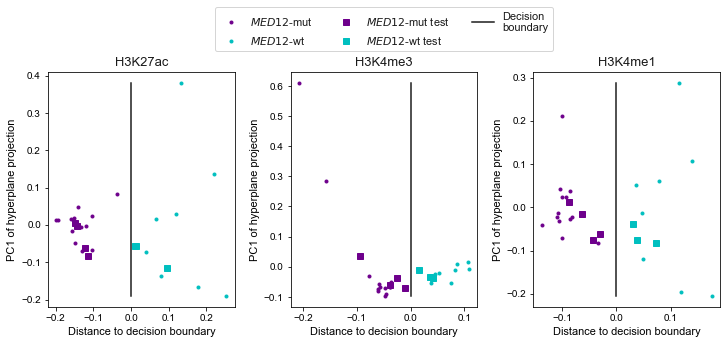

In [40]:
# SVM classification for each histone modification separately.
f, axes = plt.subplots(1, n_as, figsize=(3.4*n_as, 4.8))

for k, axis in zip(range(n_as), axes):
            
    X_MED12_single = np.copy(norm_sample_proj[1,:,k,:n_proj])
    
    clf = svm.LinearSVC(C=1.0, max_iter=10000 ,tol=1e-5, class_weight='balanced', penalty='l2', loss='squared_hinge')
    clf.fit(X_MED12_single, Y_MED12)
    print("Trianing accuracy, {}: {}".format(assay_name[k], clf.score(X_MED12_single, Y_MED12)))

    X_distToHyperplane = clf.decision_function(X_MED12_single)/np.linalg.norm(clf.coef_, ord=2)
    parallel_pc1, pca = parallelPC1(X_MED12_single, clf)

    X_add_single = additional_projections[:,k,:n_proj]

    print("Test accuracy, {}: {}".format(assay_name[k], clf.score(X_add_single, [-1, 1, 1, 1, -1, -1, -1])))
    additional_distToHyperplane = clf.decision_function(X_add_single)/np.linalg.norm(clf.coef_, ord=2)
    additional_PC = additionalDataPC1(pca, clf, X_add_single)

    l1, = axis.plot([X_distToHyperplane[j] for j in MED12mut_list],[parallel_pc1[j] for j in MED12mut_list],'.', c=(110/255, 0/255, 140/255))
    l2, = axis.plot([X_distToHyperplane[j] for j in MED12wt_list],[parallel_pc1[j] for j in MED12wt_list],'.', c=(0,0.75,0.75,1))
    l3, = axis.plot([0,0],[min(parallel_pc1),max(parallel_pc1)],'k')
    for i in range(len(X_add_single)):
        if(i in additional_MED12mut):
            l4, = axis.plot(additional_distToHyperplane[i],additional_PC[i],'s', c=(110/255, 0/255, 140/255), markersize=6)
        else:
            l5, = axis.plot(additional_distToHyperplane[i],additional_PC[i],'s', c=(0,0.75,0.75,1), markersize=6)

    if(k == 1):
        axis.legend([l1, l2, l4, l5, l3], ["$\it{MED12}$-mut", "$\it{MED12}$-wt",
                                        "$\it{MED12}$-mut test", "$\it{MED12}$-wt test", "Decision\nboundary"],
                    loc='upper center', bbox_to_anchor=(0.5,1.3), ncol=3, fontsize=11)
    
    axis.set_title(assay_name[k], fontsize=13)
    axis.set_xlabel('Distance to decision boundary',fontsize=11)
    axis.set_ylabel('PC1 of hyperplane projection',fontsize=11)
    plt.tight_layout()
    
plt.subplots_adjust(wspace=0.3)

In [41]:
## Discrete wavelet transform analysis ##
t = torch.load(input_dir + file_prefix + '_scaled_tensor.pt')

Location vector index:  3


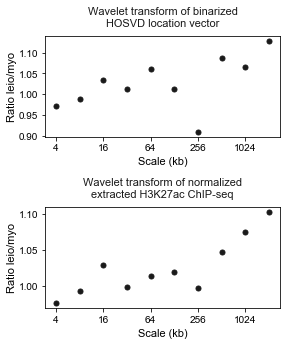

In [42]:
import pywt

# Figure 4A (leiomyoma/myometrium discrete wavelet transform plots)

# Perform the DWT for the binarized differential signal vector.

l = np.argmax(full_var_ratio)
print("Location vector index: ", l)

# Binarize the vector identified as separating leiomyoma and myometrium.
v_p = np.zeros_like(U_l[:,l])
v_n = np.zeros_like(U_l[:,l])
for i in range(len(U_l[:,l])):
    if(U_l[i,l] < -cut):
        v_n[i] = 1.0
    if(U_l[i,l] > cut):
        v_p[i] = 1.0
# Get the regions with significant alterations in histone modifications.
all_sig_regions = v_p + v_n
        
# Scale both vector to unit L2 norm.
v_p = v_p/np.linalg.norm(v_p)
v_n = v_n/np.linalg.norm(v_n)

# Compute the DWT transform for the negative and positive differential
# regions separately.
TD_coefs_p = pywt.wavedec(np.pad(v_p,203,'edge'),'coif5',level=10)
TD_coefs_n = pywt.wavedec(np.pad(v_n,203,'edge'),'coif5',level=10)
# Remove the low frequency scaling indices.
TD_coefs_p = TD_coefs_p[1:]
TD_coefs_n = TD_coefs_n[1:]
# Sum the squared wavelet indices across translation index for each scale.
scale_coefs_n = np.sqrt([sum([TD_coefs_n[j][i]**2 for i in range(len(TD_coefs_n[j]))]) for j in range(10)])
scale_coefs_p = np.sqrt([sum([TD_coefs_p[j][i]**2 for i in range(len(TD_coefs_p[j]))]) for j in range(10)])
del TD_coefs_p, TD_coefs_n

# Extract the H3K27ac signal at the differential regions for each patient
# and perform the DWT seperately for the two conditions.
scale_coefs_n_H3K27ac = np.zeros((n_pt, 10))
scale_coefs_p_H3K27ac = np.zeros((n_pt, 10))
for pt in range(n_pt):
    v_p = np.copy(t[0,pt,0,:])
    v_n = np.copy(t[1,pt,0,:])
    v_p = np.multiply(v_p, all_sig_regions)
    v_n = np.multiply(v_n, all_sig_regions)
    v_p = v_p/np.linalg.norm(v_p)
    v_n = v_n/np.linalg.norm(v_n)

    TD_coefs_p_H3K27ac = pywt.wavedec(np.pad(v_p,203,'edge'),'coif5',level=10)
    TD_coefs_n_H3K27ac = pywt.wavedec(np.pad(v_n,203,'edge'),'coif5',level=10)

    TD_coefs_p_H3K27ac = TD_coefs_p_H3K27ac[1:]
    TD_coefs_n_H3K27ac = TD_coefs_n_H3K27ac[1:]
    for j in range(10):
        scale_coefs_n_H3K27ac[pt,j] = sum([TD_coefs_n_H3K27ac[j][i]**2 for i in range(len(TD_coefs_n_H3K27ac[j]))])
        scale_coefs_p_H3K27ac[pt,j] = sum([TD_coefs_p_H3K27ac[j][i]**2 for i in range(len(TD_coefs_p_H3K27ac[j]))])
del TD_coefs_p_H3K27ac, TD_coefs_n_H3K27ac        

fig = plt.figure(figsize=(4.2, 5.0))
ax1 = fig.add_subplot(211)   

ax1.set_title('Wavelet transform of binarized\nHOSVD location vector',fontsize=11, y=1.04)

ax1.plot([i for i in range(10)], np.divide(scale_coefs_n, scale_coefs_p)[::-1], 'k.',MarkerSize=10)

ax1.set_xticklabels([str(2**(2*i)) for i in range(0,10)], fontdict=None, minor=False)
ax1.get_yaxis().set_label_coords(-0.12,0.5)
ax1.set_xlabel('Scale (kb)',fontsize=11)
ax1.set_ylabel('Ratio leio/myo',fontsize=11)

ax2 = fig.add_subplot(212)  

ax2.set_title('Wavelet transform of normalized\nextracted H3K27ac ChIP-seq',fontsize=11, y=1.04)

ax2.plot([i for i in range(10)], np.sqrt(np.divide(np.mean(scale_coefs_n_H3K27ac, axis=0), np.mean(scale_coefs_p_H3K27ac, axis=0)))[::-1], 'k.',MarkerSize=10)

ax2.set_xticklabels([str(2**(2*i)) for i in range(0,10)], fontdict=None, minor=False)
ax2.get_yaxis().set_label_coords(-0.12,0.5)
ax2.set_xlabel('Scale (kb)',fontsize=11)
ax2.set_ylabel('Ratio leio/myo',fontsize=11)

plt.subplots_adjust(hspace=0.7)

plt.savefig(output_dir + 'figures/' + 'figure4_panels/' + file_prefix +
            '_panelA_DWT_both_ratio_' + date + '.pdf', bbox_inches='tight', format='pdf')

Location vector index:  6


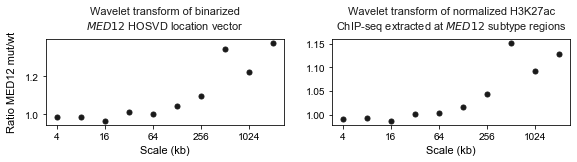

In [43]:
# Figure S4D (MED12 mutation status DWT plots)

# Repeat the DWT analysis for the vector separating MED12-mut
# and MED12-wt leiomyomas
l = np.argmax(full_var_ratio_MED12)
print("Location vector index: ", l)

v_p = np.zeros_like(U_l[:,l])
v_n = np.zeros_like(U_l[:,l])
for i in range(len(U_l[:,l])):
    if(U_l[i,l] < -cut):
        v_n[i] = 1.0
    if(U_l[i,l] > cut):
        v_p[i] = 1.0
all_sig_regions = v_n + v_p
        
v_p = v_p/np.linalg.norm(v_p)
v_n = v_n/np.linalg.norm(v_n)

TD_coefs_p = pywt.wavedec(np.pad(v_p,203,'edge'),'coif5',level=10)
TD_coefs_n = pywt.wavedec(np.pad(v_n,203,'edge'),'coif5',level=10)

TD_coefs_p = TD_coefs_p[1:]
TD_coefs_n = TD_coefs_n[1:]

scale_coefs_n = np.sqrt([sum([TD_coefs_n[j][i]**2 for i in range(len(TD_coefs_n[j]))]) for j in range(10)])
scale_coefs_p = np.sqrt([sum([TD_coefs_p[j][i]**2 for i in range(len(TD_coefs_p[j]))]) for j in range(10)])
del TD_coefs_p, TD_coefs_n

scale_coefs_n_H3K27ac = np.zeros((n_pt, 10))
for pt in range(n_pt):
    v_n = np.copy(t[1, pt, 0, :])
    v_n = np.multiply(v_n, all_sig_regions)
    v_n = v_n/np.linalg.norm(v_n)
    TD_coefs_n_H3K27ac = pywt.wavedec(np.pad(v_n, 203, 'edge'),'coif5',level=10)
    TD_coefs_n_H3K27ac = TD_coefs_n_H3K27ac[1:]
    for j in range(10):
        scale_coefs_n_H3K27ac[pt,j] = sum([TD_coefs_n_H3K27ac[j][i]**2 for i in range(len(TD_coefs_n_H3K27ac[j]))])

del TD_coefs_n_H3K27ac  

fig = plt.figure(figsize=(9.4, 6.0))
ax1 = fig.add_subplot(221)   

ax1.set_title('Wavelet transform of binarized\n$\it{MED12}$ HOSVD location vector',fontsize=11, y=1.04)

ax1.plot([i for i in range(10)], np.divide(scale_coefs_p, scale_coefs_n)[::-1], 'k.',MarkerSize=10)

ax1.set_xticklabels([str(2**(2*i)) for i in range(0,10)], fontdict=None, minor=False)
ax1.get_yaxis().set_label_coords(-0.12,0.5)
ax1.set_xlabel('Scale (kb)',fontsize=11)
ax1.set_ylabel('Ratio MED12 mut/wt',fontsize=11)

ax2 = fig.add_subplot(222)  

ax2.set_title('Wavelet transform of normalized H3K27ac\nChIP-seq extracted at $\it{MED12}$ subtype regions',fontsize=11, y=1.04)

ax2.plot([i for i in range(10)],
         np.sqrt(np.divide(np.mean(scale_coefs_n_H3K27ac[MED12mut_list], axis=0),
                           np.mean(scale_coefs_n_H3K27ac[MED12wt_list], axis=0)))[::-1],
         'k.',MarkerSize=10)

ax2.set_xticklabels([str(2**(2*i)) for i in range(0,10)], fontdict=None, minor=False)
ax2.get_yaxis().set_label_coords(-0.12,0.5)
ax2.set_xlabel('Scale (kb)',fontsize=11)

plt.subplots_adjust(hspace=1.8)

plt.savefig(output_dir + 'figures/' + 'figureS4_panels/' + file_prefix +
            '_panelD_DWT_MED12_both_ratio_' + date + '.pdf', bbox_inches='tight', format='pdf')

In [44]:
## Figure 1C, S1A, S2A,B,C,D,E,F ##

In [45]:
def matrix_cosine(X, Y):
    """Calculates the matrix cosine distance.
    
    The cosine distance is computed for matching
    rows of the X and Y matrices and these values
    are summed over the rows.
    """
    K, N = X.shape
    dist = 0.0
    for k in range(K):
        dist += scipy.spatial.distance.cosine(X[k,:], Y[k,:])
    return dist

# Calculate the adjusted matrix cosine distance between 
# each pair of tissue samples.
# Remove data for the two location vectros with outlier behavior.
use = [i for i in range(10) if (i!=4 and i!=5)]
tissue_sample = np.concatenate((sample_proj[0],sample_proj[1]))[:,:,use]
print(tissue_sample.shape)

# Mean center the data across tissue samples for each assay.
for k in range(n_as):
    tissue_sample[:,k,:] = tissue_sample[:,k,:] - np.mean(tissue_sample[:,k,:], axis=0)

D = np.zeros((n_pt*n_gr, n_pt*n_gr))
for i in range(n_pt*n_gr):
    for j in range(n_pt*n_gr):
        D[i,j] = matrix_cosine(tissue_sample[i], tissue_sample[j])

(42, 3, 8)


In [46]:
## Specify an unfolding to flatten the assay-location vector
## matrix data for each sample into a vecotr for visualizaiton.
## Also color the columns by histone modification and location vector.

col_assay_color = []
col_loc_color = []
col_labels = []
for i in range(10):
    col_assay_color.append((51/255,70/255,0,1.0))
    col_assay_color.append((204/255,102/255,0,1.0))
    col_assay_color.append((162/255,148/255,80/255,1.0))
    if(not i % 2):
        loc_color = 0.5
    else:
        loc_color = 0.0
    col_loc_color.append((loc_color,loc_color,loc_color,1.0))
    col_loc_color.append((loc_color,loc_color,loc_color,1.0))
    col_loc_color.append((loc_color,loc_color,loc_color,1.0))
    col_labels.append('H3K27ac')
    col_labels.append('H3K4me3')
    col_labels.append('H3K4me1')
    
index_order = []
for i in range(10):
    index_order.append(i)
    index_order.append(i+10)
    index_order.append(i+20)

In [47]:
## Colors and labels for mutation status to be used in plotting.
row_colors = []
for i in range(21):
    row_colors.append((1.0,0,0,1.0))

for i in range(21,42):
    if(i - 21 in MED12mut_list):
        row_colors.append((110/255, 0/255, 140/255, 1.0))
    elif(i in [22, 40]):
        row_colors.append((128/255, 128/255, 128/255, 1.0))
    elif(i in [28, 29, 34]):
        row_colors.append((0/255, 90/255, 150/255, 1.0))
    else:
        row_colors.append((30/255, 145/255, 80/255, 1.0))

colors = [(1.0, 0, 0, 1.0), (110/255, 0/255, 140/255, 1.0), (128/255, 128/255, 128/255, 1.0), (0/255, 90/255, 150/255, 1.0), (30/255, 145/255, 80/255, 1.0)]
labels = ['Myo', '$\it{MED12}$-mut', '$\it{FH}$ low', '$\it{HMGA2}$ hi', 'Unknown']

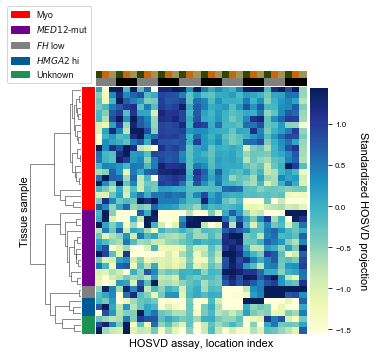

In [48]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

# Figure 1C (unsupervised hierarchical clustering of tissue samples)
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip(colors, labels)]
legend_assay = [mpatches.Patch(color=c, label=l) for c,l in zip(col_assay_color[:3], col_labels[:3])]

# Flatten the assay-location data into a vector that
# can be used for visualization.
full_sample_proj = np.concatenate((np.concatenate((sample_proj[0,:,0,:10], sample_proj[1,:,0,:10]), axis=0),
                                    np.concatenate((sample_proj[0,:,1,:10], sample_proj[1,:,1,:10]), axis=0),
                                    np.concatenate((sample_proj[0,:,2,:10], sample_proj[1,:,2,:10]), axis=0)),
                                   axis=1)
# For each assay-location vector mean center and
# and scale to unit variance across samples.
full_scaled_proj = np.divide(full_sample_proj - np.mean(full_sample_proj, axis=0), np.std(full_sample_proj,axis=0))

# Obtain a hierarchical clustering using the adjusted
# matrix cosine distance and an average linkage.
linkage = hc.linkage(sp.distance.squareform(D), method='average')

# Make the cluster map. 
g = seaborn.clustermap(full_scaled_proj[:,index_order], row_linkage=linkage, cmap="YlGnBu",
                       row_cluster=True, col_cluster=False, robust=False, row_colors=row_colors,
                       col_colors=[col_assay_color, col_loc_color],
                       xticklabels = [], yticklabels=[], figsize=(5,6),
                       vmin = np.percentile(full_scaled_proj.flatten(), 5, interpolation='nearest'),
                       vmax = np.percentile(full_scaled_proj.flatten(), 95, interpolation='nearest'))

g.ax_col_dendrogram.set_visible(False)
g.cax.set_position([0.91,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=8)
g.cax.set_ylabel('Standardized HOSVD projection', rotation=270, fontsize=11, labelpad=17)
        
l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(-0.44,1.0), handles=legend_TN,
                       frameon=True, fontsize=9)

g.ax_heatmap.set_xlabel('HOSVD assay, location index', fontsize=11)
g.ax_heatmap.set_ylabel('Tissue sample', fontsize=11)
g.ax_heatmap.yaxis.set_label_coords(-0.36,0.5)

plt.savefig(output_dir + 'figures/' + 'figure1_panels/' + file_prefix +
            '_panelC_hierarchical_clustering_HOSVD_projections_' + date + '.pdf',
             bbox_inches='tight', format='pdf')

In [49]:
# Create a legend for the columns used in Figure 1C.
fig, ax = plt.subplots(figsize=(2,2))
legend_assay = [mpatches.Patch(color=c, label=l) for c,l in zip(col_assay_color[:3], col_labels[:3])]
ax.set_axis_off()
legend = fig.legend(legend_assay, col_labels[:3], loc='center',
                    frameon=True, ncol=3, fontsize=9)
fig.canvas.draw()
# plt.show()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig(output_dir + 'figures/' + 'figure1_panels/' + file_prefix +
            '_panelC_column_legend_' + date + '.pdf',
             bbox_inches='tight', format='pdf')
plt.close()

In [50]:
# Cluster samples using RNA-seq data.
# The first 10 principal components obtained from
# RNA-seq data using DESeq2.
RNAseq_PCA = np.loadtxt(input_dir + 'leiomyoma_RNAseq_DESeq2_10PCA.csv',
                        delimiter=',', dtype=np.str)

# The patient order changes, so a different set
# of mutation labels are needed.
RNAseq_MED12mut_list = [1, 2, 3, 5, 6, 7, 8, 11, 13, 15, 17, 18]
nonRNAseq_MED12mut_list = []
for i in range(int(len(RNAseq_PCA)/2)):
    if(i not in RNAseq_MED12mut_list):
        nonRNAseq_MED12mut_list.append(i)

In [51]:
# Mutation colors and labels for the RNA-seq data.
RNA_MED12mut_list = [1, 2, 3, 5, 6, 7, 8, 11, 13, 15, 17, 18]
RNA_row_colors = []
for i in range(0,20):
    if(i in RNA_MED12mut_list):
        RNA_row_colors.append((110/255, 0/255, 140/255, 1.0))
    elif(i in [0, 14]):
        RNA_row_colors.append((128/255, 128/255, 128/255, 1.0))
    elif(i in [4, 9, 12]):
        RNA_row_colors.append((0/255, 90/255, 150/255, 1.0))
    else:
        RNA_row_colors.append((30/255, 145/255, 80/255, 1.0))
for i in range(20,40):
    RNA_row_colors.append((1.0, 0.0, 0.0, 1.0))

<Figure size 504x504 with 0 Axes>

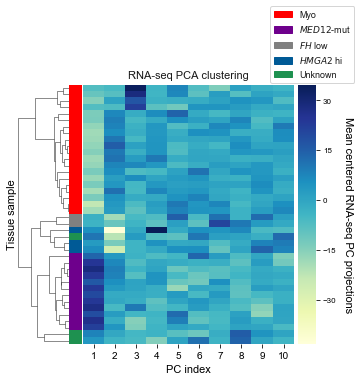

In [52]:
# Figure S1A (RNA-seq unsupervised hierarchical clustering of tissue samples)
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip(colors, labels)]

full_PCs = np.array(RNAseq_PCA[:,:10], dtype=np.float)

full_centered_PCs = np.transpose(np.transpose(full_PCs) - np.mean(np.transpose(full_PCs), axis=0))

fig = plt.figure(figsize=(7,7))

g = seaborn.clustermap(full_centered_PCs, metric='cosine', method='average', cmap="YlGnBu",
                       robust=False, col_cluster=False, row_colors=RNA_row_colors,
                       xticklabels=[str(i+1) for i in range(10)], yticklabels=[], figsize=(5,6))


g.ax_col_dendrogram.set_visible(False)
g.cax.set_position([0.91,0.125,0.05,0.6])
plt.setp(g.cax.get_yticklabels(), fontsize=8)
g.cax.set_ylabel('Mean centered RNA-seq PC projections', rotation=270, fontsize=11, labelpad=17)


l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(0.865,0.99), handles=legend_TN,
                       frameon=True, fontsize=9, ncol=1)
g.ax_heatmap.set_title('RNA-seq PCA clustering', fontsize=11)
g.ax_heatmap.set_xlabel('PC index', fontsize=11)
g.ax_heatmap.set_ylabel('Tissue sample', fontsize=11)
g.ax_heatmap.yaxis.set_label_coords(-0.36,0.5)

g.savefig(output_dir + 'figures/' + 'figureS1_panels/' + 
          '_panelA_hierarchical_clustering_RNAseq_PCA_' +
          date + '.pdf', format='pdf')

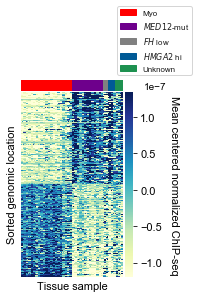

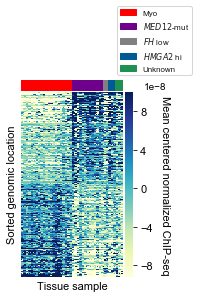

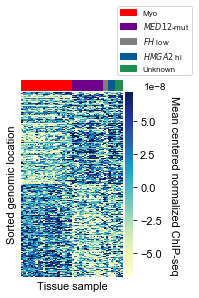

In [53]:
# Figures 2A-C
loc_order = np.argsort(U_l[:,3])
for k in range(n_as):
    
    ## For each tissue sample extract the normalized ChIP-seq
    ## signal at the 3000 genomic bins with the most positive 
    ## component on the fourth location vector, and the 3000
    ## genomic bins with the most negative component on the 
    ## fourth location vector.
    condition_stacked_array = np.concatenate((t[0,:,k,loc_order], t[1,:,k,loc_order]))
    end_regions = np.concatenate((condition_stacked_array[:,:3000], condition_stacked_array[:,-3000:]), axis=1)
    del condition_stacked_array
    ## Mean center the columns (sorted genomic bins).
    end_regions = end_regions - np.mean(end_regions, axis=0)
    
    g = seaborn.clustermap(np.transpose(end_regions), col_linkage=linkage,
                           row_cluster=False, col_cluster=True, cmap="YlGnBu",
                           robust=True, col_colors=row_colors,
                           vmin = np.percentile(end_regions, 10, axis=None, interpolation='nearest'),
                           vmax = np.percentile(end_regions, 90, axis=None, interpolation='nearest'),
                           xticklabels = [], yticklabels=[] , figsize=(2.3,4.5))

    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)

    g.cax.set_position([0.91,0.125,0.05,0.57])
    plt.setp(g.cax.get_yticklabels(), fontsize=11)
    g.cax.set_ylabel('Mean centered normalized ChIP-seq', rotation=270, fontsize=11, labelpad=17)
    g.cax.get_yaxis().get_offset_text().set_x(5.0)


    g.ax_heatmap.yaxis.set_label_position("left")

    l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(0.9,1.07,0.1,0.1), handles=legend_TN,
                           frameon=True, fontsize=8)

    g.ax_heatmap.set_xlabel('Tissue sample', fontsize=11)
    g.ax_heatmap.set_ylabel('Sorted genomic location', fontsize=11)

    g.savefig(output_dir + 'figures/' + 'figureS2_panels/' +
              '_sorted_location_heatmap_' + assay_name[k] + '_' +
              date + '.png', dpi=300, format='png')

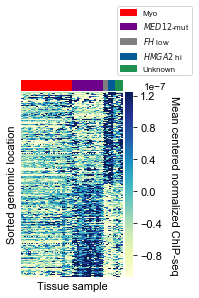

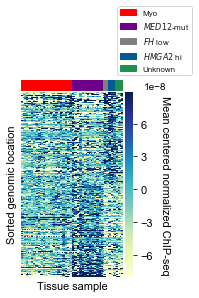

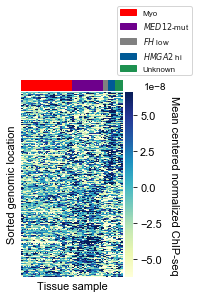

In [54]:
# Figures 2D-F
loc_order = np.argsort(U_l[:,6])
for k in range(n_as):
    
    ## For each tissue sample extract the normalized ChIP-seq
    ## signal at the 3000 genomic bins with the most positive 
    ## component on the seventh location vector, and the 3000
    ## genomic bins with the most negative component on the 
    ## seventh location vector.
    condition_stacked_array = np.concatenate((t[0,:,k,loc_order], t[1,:,k,loc_order]))
    end_regions = np.concatenate((condition_stacked_array[:,:3000], condition_stacked_array[:,-3000:]), axis=1)
    del condition_stacked_array
    ## Mean center the columns (sorted genomic bins).
    end_regions = end_regions - np.mean(end_regions, axis=0)

    g = seaborn.clustermap(np.transpose(end_regions), col_linkage=linkage,
                           row_cluster=False, col_cluster=True, cmap="YlGnBu",
                           robust=True, col_colors=row_colors,
                           vmin = np.percentile(end_regions, 10, axis=None, interpolation='nearest'),
                           vmax = np.percentile(end_regions, 90, axis=None, interpolation='nearest'),
                           xticklabels = [], yticklabels=[] , figsize=(2.3,4.5))

    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)

    g.cax.set_position([0.91,0.125,0.05,0.57])
    plt.setp(g.cax.get_yticklabels(), fontsize=11)
    g.cax.set_ylabel('Mean centered normalized ChIP-seq', rotation=270, fontsize=11, labelpad=17)
    g.cax.get_yaxis().get_offset_text().set_x(5.0)


    g.ax_heatmap.yaxis.set_label_position("left")

    l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(0.9,1.07,0.1,0.1), handles=legend_TN,
                           frameon=True, fontsize=8)

    g.ax_heatmap.set_xlabel('Tissue sample', fontsize=11)
    g.ax_heatmap.set_ylabel('Sorted genomic location', fontsize=11)

    g.savefig(output_dir + 'figures/' + 'figureS2_panels/' +
              '_loc6_MED12_sorted_location_heatmap_' + assay_name[k] 
              + '_' + date + '.png', dpi=300, format='png')